<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the essentials

In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision as tv
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("input"))
base_dir = "input/aptos2019-blindness-detection/"

['aptos2019-blindness-detection', 'kernelwong']


In [2]:
print(os.listdir("input/kernelwong"))

['classifier.pt', 'custom.css', 'notebook.ipynb', 'output.json', 'result.html', 'result_files']


In [3]:
import seaborn as sns

# Loading Data + EDA

In [4]:
train_csv = pd.read_csv('input/aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('input/aptos2019-blindness-detection/test.csv')

In [5]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [6]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


C:\Users\mh\AppData\Local\Temp\ipykernel_14408\2592501661.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(counts.values, alpha=0.8, palette='bright')


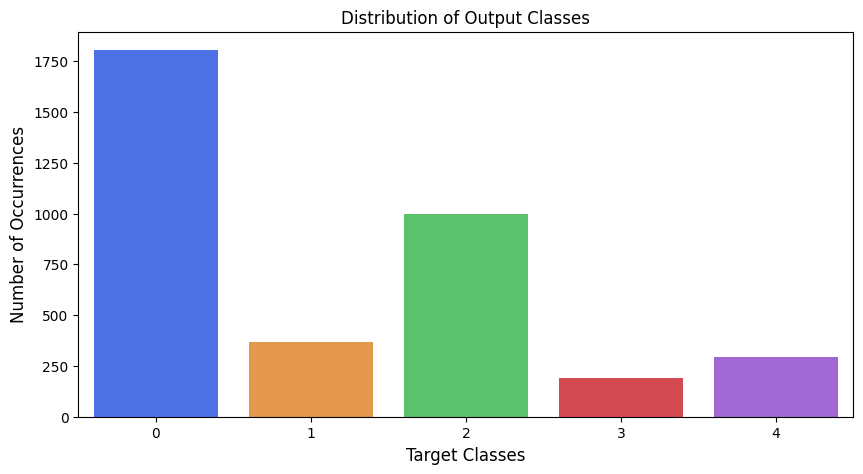

In [7]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

# Visualizing Training Data

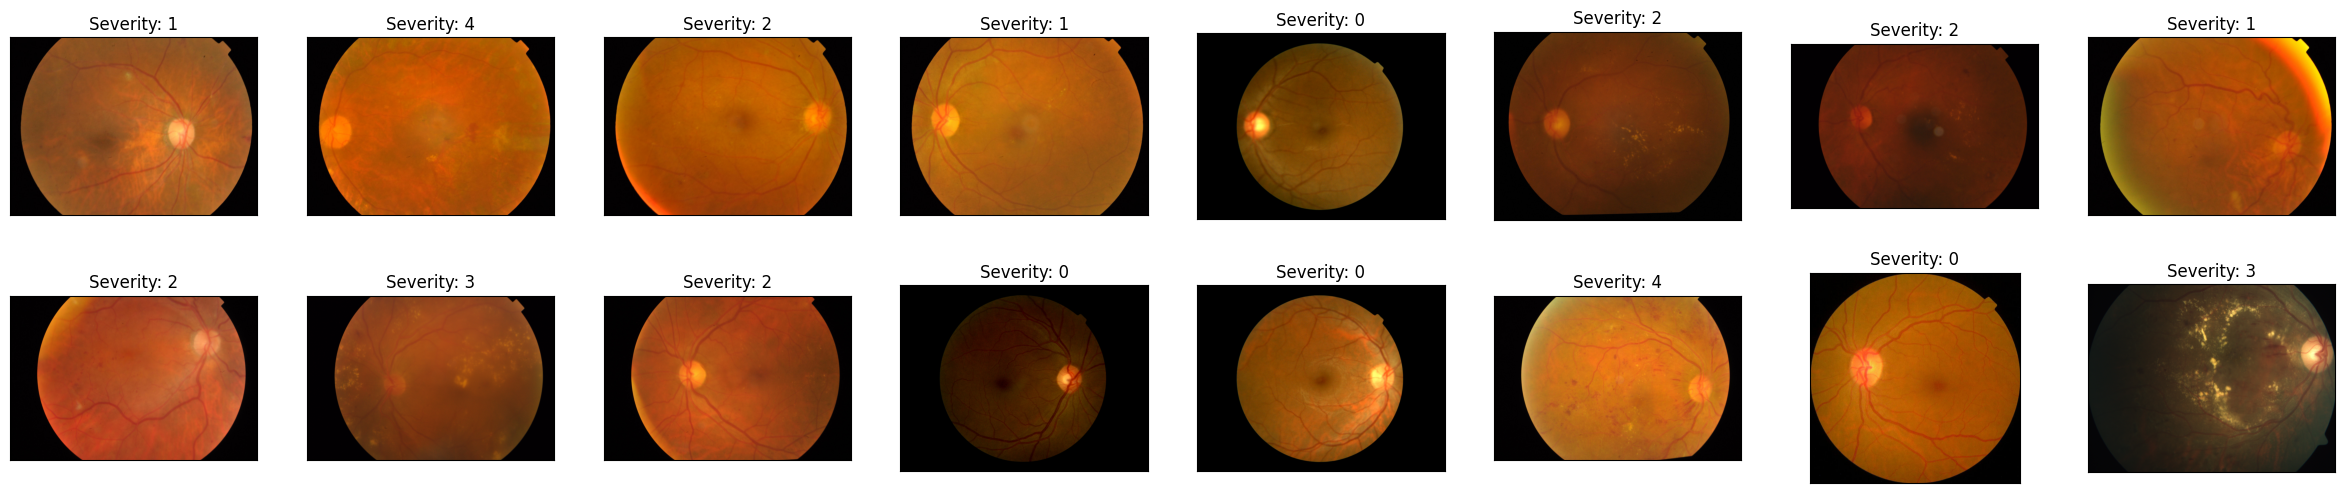

In [8]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Visualizing Test Set

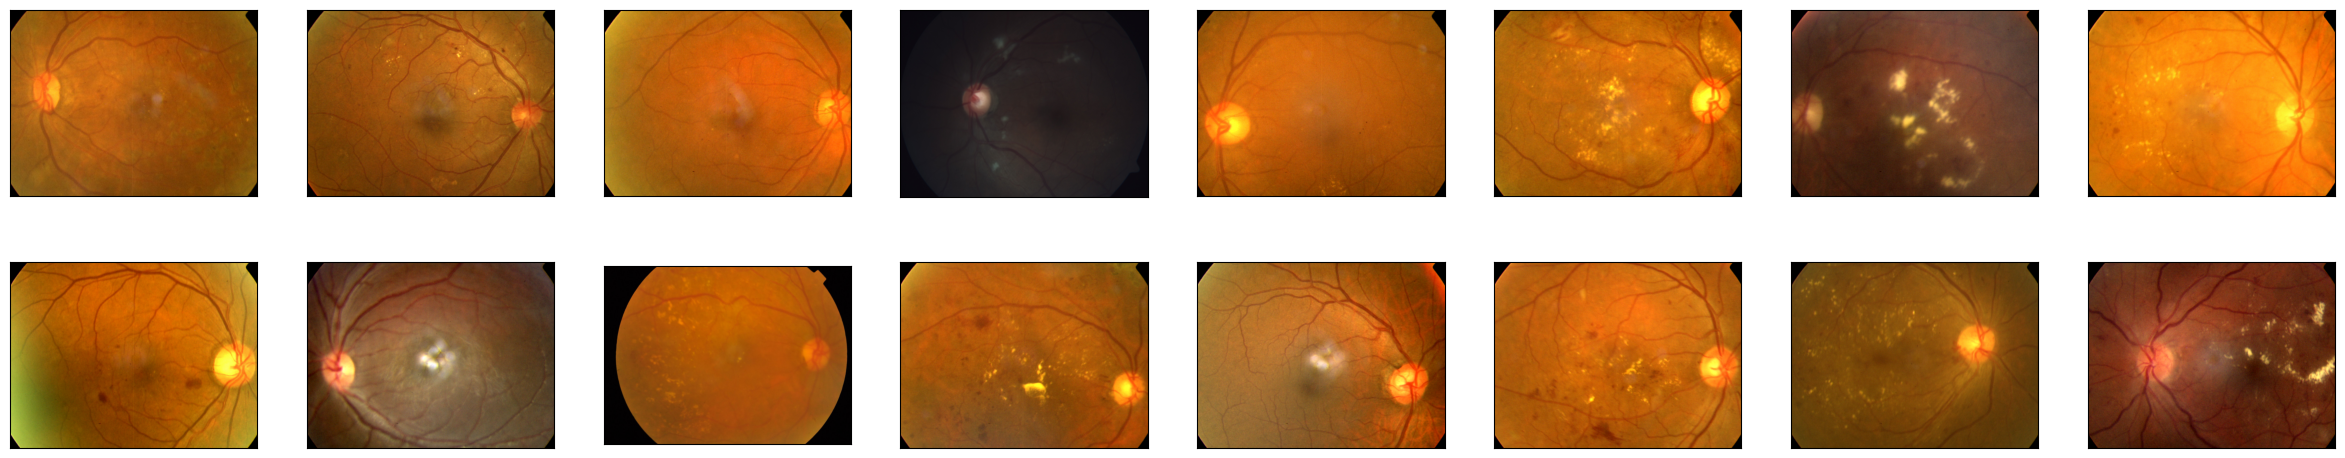

In [9]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

# Data Processing

In [10]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = 'input', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [12]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [13]:
train_path = "input/aptos2019-blindness-detection/train_images/"
test_path = "input/aptos2019-blindness-detection/test_images/"

In [14]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
    

In [15]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [16]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [17]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [18]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 1928
46
12
31


In [19]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS

images, labels= next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([1, 0, 2, 0, 0, 0, 0, 2, 0, 3, 0, 1, 3, 3, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0,
        3, 4, 2, 0, 0, 2, 0, 0, 3, 2, 1, 0, 2, 3, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1,
        0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 0])


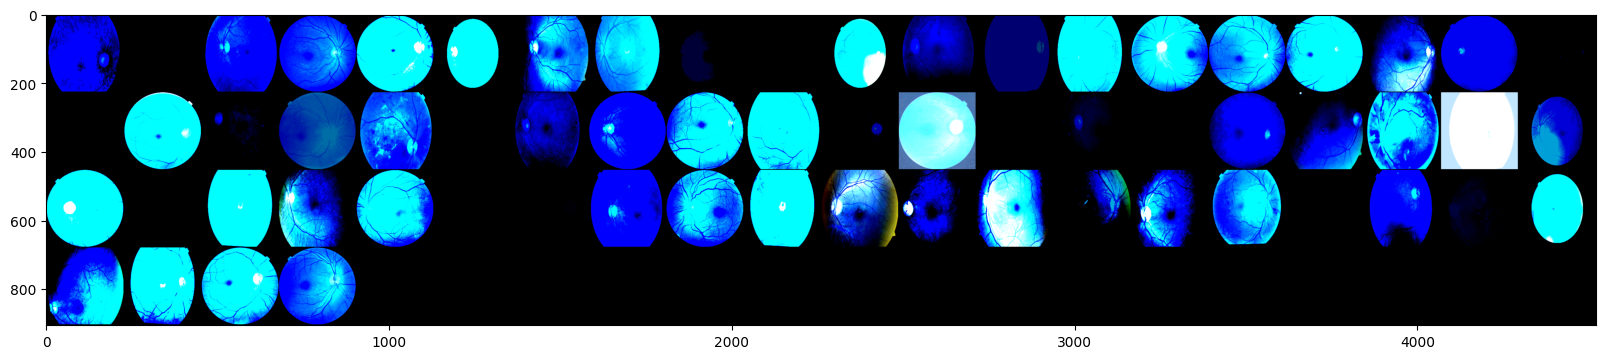

In [20]:
# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

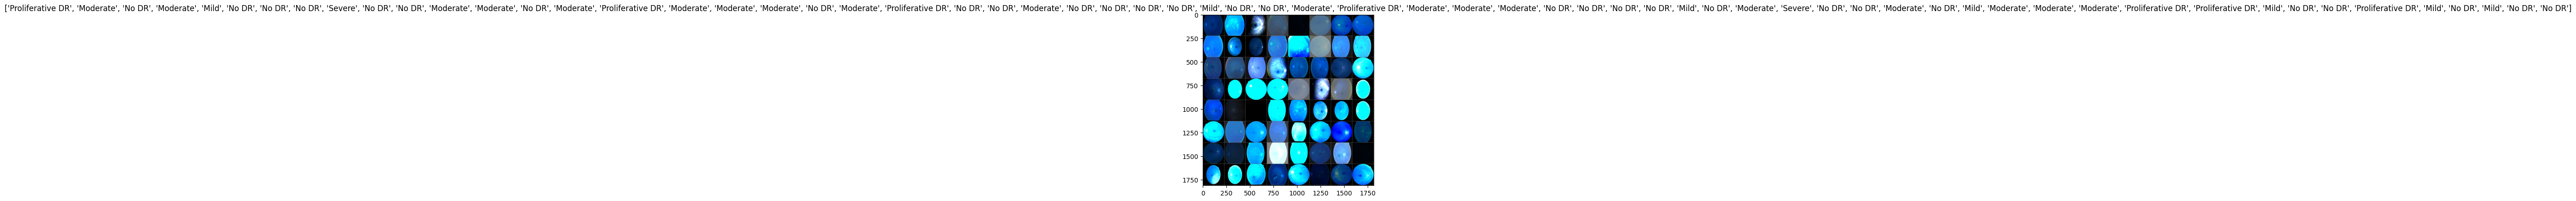

In [21]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [22]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=True) #pretrained

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)

c:\Users\mh\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
#model_save_name = 'classifier.pt'
#path = f"input/kernelwong/{model_save_name}"

path = "input/kernelwong/classifier.pt"

torch.save({'epoch': 1,
          'model': model,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': 1.0
          }, path)

In [25]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [26]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [27]:
def load_model(model, optimizer, path):
  checkpoint = torch.load(path)

  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  #model.load_state_dict(checkpoint('model_state_dict'))
  #optimizer.load_state_dict(checkpoint('optimizer_state_dict'))

  return model, optimizer

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, optimizer = load_model(model, optimizer, "input/kernelwong/classifier.pt")

In [29]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [31]:
import numpy as np

def train_and_test(e, model, optimizer, criterion, trainloader, validloader, path):
  epochs = e
  train_losses , test_losses, acc = [] , [], []
  valid_loss_min = np.Inf 
  model.train()
  print("Model Training started.....")

  for epoch in range(epochs):
    running_loss = 0
    batch = 0

    for images , labels in trainloader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      batch += 1
      if batch % 10 == 0:
          print(f" epoch {epoch + 1} batch {batch} completed") 

    test_loss = 0
    accuracy = 0
    with torch.no_grad():
      print(f"validation started for {epoch + 1}")
      model.eval() 
      for images , labels in validloader:
        images, labels = images.to(device), labels.to(device)
        logps = model(images) 
        test_loss += criterion(logps,labels) 
        ps = torch.exp(logps)
        top_p , top_class = ps.topk(1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(validloader))
    acc.append(accuracy)
    scheduler.step()
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
          "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
    
    model.train() 

    if test_loss/len(validloader) <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
      torch.save({
          'epoch': epoch,
          'model': model,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': valid_loss_min
          }, path)
      valid_loss_min = test_loss/len(validloader)   
       
  print('Training Completed Succesfully !')    
  return train_losses, test_losses, acc 

In [32]:
train_losses, valid_losses, acc = train_and_test(5, model, optimizer, criterion, trainloader, validloader, 'model_checkpoint.pth')

Model Training started.....


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

NameError: name 'plt' is not defined

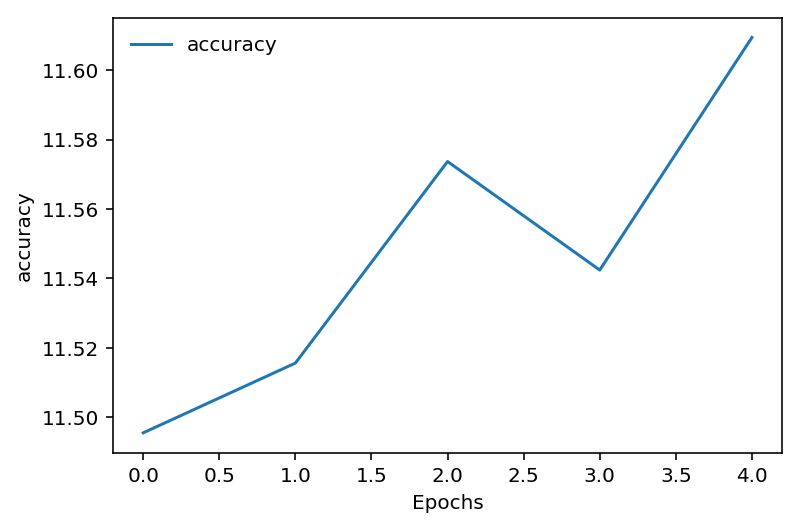

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)